<a id="inicio"></a>
<img src="http://www.cidaen.es/assets/img/mCIDaeNnb.png" alt="Logo CiDAEN" align="right">




<br><br><br>
<h2><font color="#00586D" size=4>Trabajo fín de master</font></h2>



<h1><font color="#00586D" size=5>Predicción de duración de dosificación para corrección de colas<br> en procesos automáticos de fabricación de pienso</font></h1>

<br><br><br>
<div style="text-align: right">
<font color="#00586D" size=3>Autor: Jose Luís Casado Valero</font><br>
<font color="#00586D" size=3>Tutor: Luís de la Ossa Jiménez</font><br>
<font color="#00586D" size=3>Máster en Ciencia de Datos e Ingeniería de Datos en la Nube</font><br>
<font color="#00586D" size=3>Universidad de Castilla-La Mancha</font>
</div>

In [1]:
#!pip install pandas
#!pip install numpy
#!pip install seaborn
#!pip install matplotlib

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns;
sns.set()

# Optimiza los gráficos para pantalla retina
%config InlineBackend.figure_format = 'retina'
# Por defecto usamos el backend inline
%matplotlib inline

# La libreta ocupa así el 95% de la pantalla
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

<a id="indice"></a>
<h2><font color="#00586D" size=5>Índice</font></h2>


* [1. Introducción](#section1)
* [2. Carga de datos](#section2)
* [3. Generación de variables calculadas](#section3)
* [4. Exploración de valores y sus estadísticos](#section4)
* [5. Filtrado de datos tras la exploración](#section5)
* [6. Generación de características y eliminación de columnas](#section6)
* [7. Construcción de características](#section7)
* [8. Preprocesamiento](#section8)
* [9. División en train y test](#section9)
* [10. Entrenamiento de modelos](#section10)

<div style="text-align: right">
<a href="#inicio"><font size=5><i class="fa fa-arrow-circle-up" aria-hidden="true" style="color:#00586D"></i></font></a>
</div>

---

<a id="section1"></a>
## <font color="#00586D"> 1. Introducción</font>
<br>

La idea de este trabajo fin de máster es, teniendo información de las dosificaciones realizadas en los últimos años en una fábrica, en torno a los 0,4 millones, realizar un trabajo de limpieza, estudio, creación de características y obtención de un modelo que sea capaz de predecir la duración temporal de la próxima dosificación y con ello corregir la cola de caída utilizada y evitar las desviaciones esporádicas.

<div style="text-align: right">
<a href="#inicio"><font size=5><i class="fa fa-arrow-circle-up" aria-hidden="true" style="color:#00586D"></i></font></a>
</div>

---

<a id="section2"></a>
## <font color="#00586D"> 2. Carga de datos</font>
<br>

Cargamos los datos en un DataFrame de pandas, mostramos sus primeras filas y su información para su posterior exploración.

In [2]:
df_dosificaciones = pd.read_csv('datos/datos211008.zip', compression='zip', \
                    sep=',', na_values='\\N', index_col='codigo', \
                    parse_dates=['fecha_inicio', 'fecha_fin'])
df_dosificaciones.head(5)

,fecha_inicio,fecha_fin,cantidad_solicitada,cantidad_dosificada,mezcla,pesada,peso_inicial,manual,id_lote_destino,materia_origen,materia_destino,id_silo,tipo_materia,tipo_destino,densidad,tam_mezcla,desviacion
codigo,,,,,,,,,,,,,,,,,
1308958,2018-01-01 21:58:18,2018-01-01 22:00:15,1600.078404,1606.0,1,0,-12,0,232527,8,285,1,Prima,Formula,1,4000,5.921596
1308975,2018-01-01 22:05:50,2018-01-01 22:07:48,1600.078404,1602.0,2,0,-21,0,232527,8,285,1,Prima,Formula,1,4000,1.921596
1308987,2018-01-01 22:13:08,2018-01-01 22:15:06,1600.078404,1596.0,3,0,-29,0,232527,8,285,1,Prima,Formula,1,4000,-4.078404
1309003,2018-01-01 22:20:17,2018-01-01 22:22:15,1600.078404,1600.0,4,0,-29,0,232527,8,285,1,Prima,Formula,1,4000,-0.078404
1309022,2018-01-01 22:27:53,2018-01-01 22:29:52,1600.078404,1598.0,5,0,-29,0,232527,8,285,1,Prima,Formula,1,4000,-2.078404


2.- Exploracion de datos

In [3]:
df_dosificaciones.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 395477 entries, 1308958 to 3014892
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   fecha_inicio         395477 non-null  datetime64[ns]
 1   fecha_fin            395477 non-null  datetime64[ns]
 2   cantidad_solicitada  395477 non-null  float64       
 3   cantidad_dosificada  395477 non-null  float64       
 4   mezcla               395477 non-null  int64         
 5   pesada               395477 non-null  int64         
 6   peso_inicial         395477 non-null  int64         
 7   manual               395477 non-null  int64         
 8   id_lote_destino      395477 non-null  int64         
 9   materia_origen       395477 non-null  int64         
 10  materia_destino      395477 non-null  int64         
 11  id_silo              395477 non-null  int64         
 12  tipo_materia         395477 non-null  object        
 13  tipo_de

<div style="text-align: right">
<a href="#inicio"><font size=5><i class="fa fa-arrow-circle-up" aria-hidden="true" style="color:#00586D"></i></font></a>
</div>

---

<a id="section3"></a>
## <font color="#00586D"> 3. Generación de variables calculadas</font>
<br>

Como hemos comentado, la variable a predecir será la duración de la dosificación, para el entrenamiento, esta variable la obtendremos calculando los segundos que pasan desde en inicio de la dosificación hasta su finalización.
<br>
<br>
También generaremos una nueva caracteristica que nos puede ayudar a caracterizar el problema, el orden de cada una de las dosificaciones dentro de la mezcla correspondiente, para ello generamos una función que va recorriendo el dataset ordenadamente y en función de la mezcla, lote destino y pesada va a calculando el orden o número de cada dosificación.
<br>
<br>
Por último guardaremos los datos generados en disco para no tener que realizar esta operación en futuros experimentos.

In [4]:
df_dosificaciones['duracion'] = df_dosificaciones['fecha_fin'] - df_dosificaciones['fecha_inicio']
df_dosificaciones['duracion'] = df_dosificaciones['duracion'].dt.seconds

In [5]:
df_dosificaciones.head()

,fecha_inicio,fecha_fin,cantidad_solicitada,cantidad_dosificada,mezcla,pesada,peso_inicial,manual,id_lote_destino,materia_origen,materia_destino,id_silo,tipo_materia,tipo_destino,densidad,tam_mezcla,desviacion,duracion
codigo,,,,,,,,,,,,,,,,,,
1308958,2018-01-01 21:58:18,2018-01-01 22:00:15,1600.078404,1606.0,1,0,-12,0,232527,8,285,1,Prima,Formula,1,4000,5.921596,117
1308975,2018-01-01 22:05:50,2018-01-01 22:07:48,1600.078404,1602.0,2,0,-21,0,232527,8,285,1,Prima,Formula,1,4000,1.921596,118
1308987,2018-01-01 22:13:08,2018-01-01 22:15:06,1600.078404,1596.0,3,0,-29,0,232527,8,285,1,Prima,Formula,1,4000,-4.078404,118
1309003,2018-01-01 22:20:17,2018-01-01 22:22:15,1600.078404,1600.0,4,0,-29,0,232527,8,285,1,Prima,Formula,1,4000,-0.078404,118
1309022,2018-01-01 22:27:53,2018-01-01 22:29:52,1600.078404,1598.0,5,0,-29,0,232527,8,285,1,Prima,Formula,1,4000,-2.078404,119


In [6]:
df_dosificaciones = df_dosificaciones.sort_values(['codigo'])
df_dosificaciones['orden'] = 0
hskeys = {}
for key, row in df_dosificaciones.iterrows():
    hskey = str(row['mezcla'])+"-"+str(row['id_lote_destino'])+"-"+str(row['pesada'])
    valor = 0
    if (hskey in hskeys):
        valor = hskeys[hskey]
    
    hskeys[hskey] = valor + 1
    df_dosificaciones['orden'][key] = hskeys[hskey]

/Users/jlcasado/MCIDAEN/mc1-tfm/venv/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [7]:
# Guardo los datos por ahorrar tiempo en posteriores pruebas
df_dosificaciones.to_csv('datos/data_parser.zip', compression='zip')

In [18]:
df_dosificaciones = pd.read_csv('datos/data_parser.zip', compression='zip', \
                    sep=',', na_values='\\N', index_col='codigo', \
                    parse_dates=['fecha_inicio', 'fecha_fin'])

<div style="text-align: right">
<a href="#inicio"><font size=5><i class="fa fa-arrow-circle-up" aria-hidden="true" style="color:#00586D"></i></font></a>
</div>

---

<a id="section4"></a>
## <font color="#00586D"> 4. Exploración de valores y sus estadísticos</font>
<br>

En este apartado realizaremos deferentes tareas de exploración de los datos: 
<br><br>
<ol type=”A”>
  <li>Búsqueda de valores perdidos. En este caso no apreciamos ninguno.</li>
  <li>Valores únicos para variables categóricas</li>
  <li>Estadísticos de variables numéricas y su gráfica</li>
</ol>

In [19]:
df_dosificaciones.isnull().sum()

fecha_inicio           0
fecha_fin              0
cantidad_solicitada    0
cantidad_dosificada    0
mezcla                 0
pesada                 0
peso_inicial           0
manual                 0
id_lote_destino        0
materia_origen         0
materia_destino        0
id_silo                0
tipo_materia           0
tipo_destino           0
densidad               0
tam_mezcla             0
desviacion             0
duracion               0
orden                  0
dtype: int64

In [20]:
for col in df_dosificaciones:
    if (df_dosificaciones[col].nunique() < 5):
        print(col + ": ")
        print(df_dosificaciones[col].unique())

pesada: 
[0 1]
manual: 
[0]
tipo_materia: 
['Prima']
tipo_destino: 
['Formula']
densidad: 
[1]


6.- Obtengo los estadisticos de las variables numericas

In [21]:
df_dosificaciones[['cantidad_solicitada','cantidad_dosificada', \
                   'peso_inicial','tam_mezcla', 'duracion', 'desviacion']].describe()

,cantidad_solicitada,cantidad_dosificada,peso_inicial,tam_mezcla,duracion,desviacion
count,395477.000000,395477.000000,395477.000000,395477.000000,395477.000000,395477.000000
mean,801.251668,800.430925,1342.961790,4000.817393,37.613821,-0.820743
std,744.934627,745.126502,1249.587527,211.905637,37.362577,30.448675
min,0.000000,0.000000,-64.000000,400.000000,0.000000,-2623.091942
25%,167.984881,168.000000,11.000000,4000.000000,16.000000,-3.000000
50%,668.040000,664.000000,1574.000000,4000.000000,25.000000,0.004000
75%,1163.096968,1168.000000,2600.000000,4040.000000,49.000000,3.019802
max,3121.984940,3127.000000,3995.000000,4500.000000,7786.000000,1179.891694


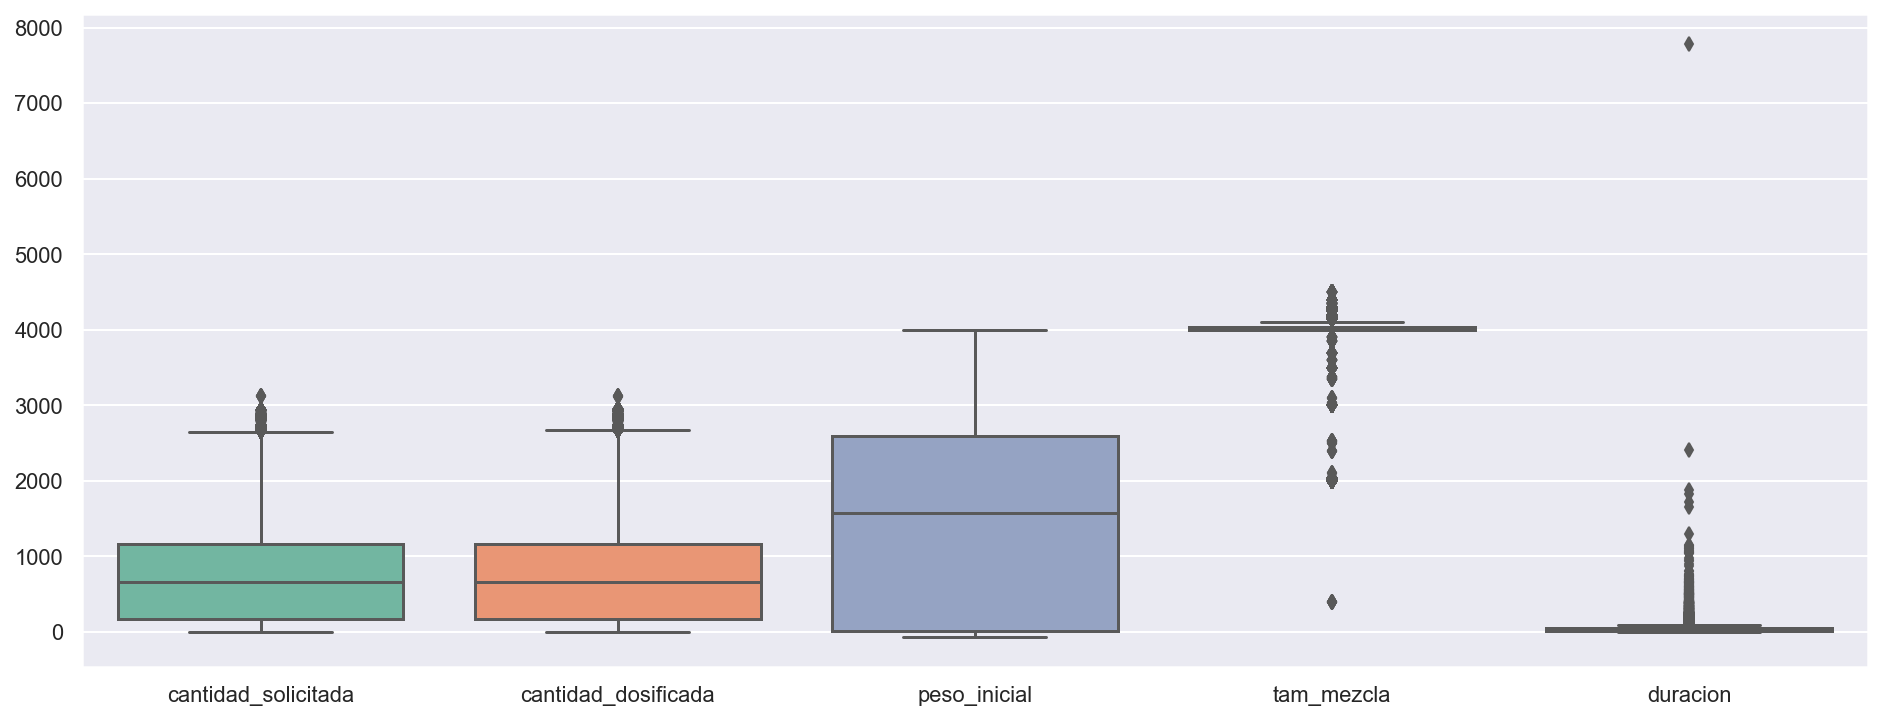

In [22]:
plt.figure(figsize=(16, 6))
sns.boxplot(data=df_dosificaciones[['cantidad_solicitada','cantidad_dosificada','peso_inicial','tam_mezcla', 'duracion']], palette="Set2")

plt.show()

<div style="text-align: right">
<a href="#inicio"><font size=5><i class="fa fa-arrow-circle-up" aria-hidden="true" style="color:#00586D"></i></font></a>
</div>

---

<a id="section5"></a>
## <font color="#00586D"> 5. Filtrado de datos tras la exploración</font>
<br>

Con la información obtenida y las decisiones tomas pasamos se filtran los datos que consideramos ruido, quedándonos para nuestro aprendizaje lo que cumplen los siguientes criterios: 

<ol type="A">
    <li>Cantidad solicitada mayor de 0.</li>
    <li>Cantidad solicitada menor de 1300.</li>
    <li>Cantidad dosificada mayor de 1.</li>
    <li>Cantidad dosificada menor de 1400.</li>
    <li>Desviación > -100.</li>
    <li>Desviación < 100.</li>
    <li>Peso inicial de la báscula menor de 2700.</li>
    <li>Duración menor de 120 segundos.</li>
</ol>
<br>
También eliminaremos las columnas que consideramos que no aportan información
<br><br>

In [23]:
df_dosificaciones = df_dosificaciones[(df_dosificaciones['cantidad_solicitada'] > 0) &
                  (df_dosificaciones['cantidad_solicitada'] < 1300) &
                  (df_dosificaciones['cantidad_dosificada'] > 1) &
                  (df_dosificaciones['cantidad_dosificada'] < 1400) &
                  (df_dosificaciones['desviacion'] > -100) &
                  (df_dosificaciones['desviacion'] < 100) &
                  (df_dosificaciones['peso_inicial'] < 2700) &
                  (df_dosificaciones['duracion'] < 120)]

In [24]:
df_dosificaciones.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 235045 entries, 1308973 to 3211250
Data columns (total 19 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   fecha_inicio         235045 non-null  datetime64[ns]
 1   fecha_fin            235045 non-null  datetime64[ns]
 2   cantidad_solicitada  235045 non-null  float64       
 3   cantidad_dosificada  235045 non-null  float64       
 4   mezcla               235045 non-null  int64         
 5   pesada               235045 non-null  int64         
 6   peso_inicial         235045 non-null  int64         
 7   manual               235045 non-null  int64         
 8   id_lote_destino      235045 non-null  int64         
 9   materia_origen       235045 non-null  int64         
 10  materia_destino      235045 non-null  int64         
 11  id_silo              235045 non-null  int64         
 12  tipo_materia         235045 non-null  object        
 13  tipo_de

In [25]:
columns_delete = ['fecha_fin','cantidad_dosificada', \
                  'manual','densidad','tipo_materia', \
                  'tipo_destino','id_lote_destino','desviacion','mezcla','pesada']
df_dosificaciones.drop(columns=columns_delete, inplace=True)

In [26]:
df_dosificaciones.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 235045 entries, 1308973 to 3211250
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   fecha_inicio         235045 non-null  datetime64[ns]
 1   cantidad_solicitada  235045 non-null  float64       
 2   peso_inicial         235045 non-null  int64         
 3   materia_origen       235045 non-null  int64         
 4   materia_destino      235045 non-null  int64         
 5   id_silo              235045 non-null  int64         
 6   tam_mezcla           235045 non-null  int64         
 7   duracion             235045 non-null  int64         
 8   orden                235045 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(7)
memory usage: 17.9 MB


<div style="text-align: right">
<a href="#inicio"><font size=5><i class="fa fa-arrow-circle-up" aria-hidden="true" style="color:#00586D"></i></font></a>
</div>

---

<a id="section6"></a>
## <font color="#00586D"> 6. Generación de características y eliminación de columnas</font>
<br>

Es fácil pensar que las desviaciones de las dosificaciones y por tanto la duración de las mismas tenga un cierto caracter temporal o cíclico a lo largo del tiempo, por ello generaremos dos características en este sentido, con información de la hora a la que se produce la pesada y el día de la semana.
<br><br>
Otro indicativo de la duración de la dosificación es el estado de la propia materia, que puede cambiar en función de las condiciones de temperatura y humedad en la fábrica. Como no disponemos de esta información, la descargaremos de la API REST de AEMET OpenData y la añadiremos a nuestro dataset.
<br><br>
Para finalizar, eliminaremos las columnas con información no relevante para nuestro modelo.

In [27]:
#df_dosificaciones['mes'] = pd.DatetimeIndex(df_dosificaciones['fecha_inicio']).month
#df_dosificaciones['dia'] = pd.DatetimeIndex(df_dosificaciones['fecha_inicio']).day
df_dosificaciones['hora'] = pd.DatetimeIndex(df_dosificaciones['fecha_inicio']).hour
df_dosificaciones['dow'] = pd.DatetimeIndex(df_dosificaciones['fecha_inicio']).dayofweek

In [28]:
df_dosificaciones.head(5)

,fecha_inicio,cantidad_solicitada,peso_inicial,materia_origen,materia_destino,id_silo,tam_mezcla,duracion,orden,hora,dow
codigo,,,,,,,,,,,
1308973,2018-01-01 22:02:11,768.557659,2,184,285,14,4000,41,1,22,0
1308978,2018-01-01 22:07:49,1187.738199,1581,176,285,15,4000,46,2,22,0
1308982,2018-01-01 22:09:37,768.557659,0,184,285,13,4000,26,1,22,0
1308988,2018-01-01 22:15:06,1187.738199,1568,176,285,15,4000,47,2,22,0
1308994,2018-01-01 22:16:43,768.557659,-19,184,285,13,4000,26,1,22,0


In [29]:
df_meteo = pd.read_csv('datos/datosMeteo.csv', \
                    sep=',', na_values='\\N',  \
                    parse_dates=['fecha','horatmin','horatmax','horaracha'])
df_meteo.rename(columns={'fecha':'fecha_inicio'}, inplace=True)
df_meteo.head(5)

,fecha_inicio,nombre,provincia,altitud,tmed,prec,tmin,horatmin,tmax,horatmax,dir,velmedia,racha,horaracha
0,2018-01-01,CARTAGENA,MURCIA,17,14.1,0.0,10.8,2018-01-01 08:00:00,17.4,2018-01-01 00:10:00,19,1.7,9.7,2018-01-01 15:10:00
1,2018-01-01,SAN JAVIER AEROPUERTO,MURCIA,4,13.8,0.0,8.2,2018-01-01 22:06:00,19.3,2018-01-01 11:51:00,32,4.7,12.8,2018-01-01 00:22:00
2,2018-01-02,CARTAGENA,MURCIA,17,14.3,0.0,10.2,2018-01-02 08:00:00,18.4,2018-01-02 12:20:00,18,1.1,4.7,2018-01-02 14:50:00
3,2018-01-02,SAN JAVIER AEROPUERTO,MURCIA,4,15.4,0.0,8.0,2018-01-02 02:58:00,22.7,2018-01-02 14:28:00,30,4.7,11.7,2018-01-02 23:45:00
4,2018-01-03,CARTAGENA,MURCIA,17,16.0,0.0,11.7,2018-01-03 05:00:00,20.3,2018-01-03 15:10:00,16,0.8,6.4,2018-01-03 16:00:00


Hemos obtenido la informacion meteorologica de las dos estaciones mas cercanas a la fabrica, y mas o menos estan a la misma distancia, 
quedando etre ellas la propia fabrica, por lo que calcularemos la media de los valores de las dos.

In [30]:
df_meteo_group = df_meteo.groupby(['fecha_inicio']).mean()
df_meteo_group.head()

,altitud,tmed,prec,tmin,tmax,dir,velmedia,racha
fecha_inicio,,,,,,,,
2018-01-01,10.5,13.95,0.0,9.5,18.35,25.5,3.20,11.25
2018-01-02,10.5,14.85,0.0,9.1,20.55,24.0,2.90,8.20
2018-01-03,10.5,17.70,0.0,12.7,22.70,24.0,2.35,10.15
2018-01-04,10.5,15.85,0.0,11.0,20.70,23.0,1.70,11.25
2018-01-05,10.5,13.20,0.0,8.0,18.45,18.0,1.65,5.85


Nos quedamos solo con los datos del dia en nuestra fecha de las dosificaciones para hacer el merge con nuestra tabla de datos meteorologicos

In [31]:
df_dosificaciones['fecha_inicio'] = df_dosificaciones['fecha_inicio'].dt.normalize()

In [32]:
df_dosificaciones = pd.merge(df_dosificaciones, df_meteo_group, on='fecha_inicio')

In [34]:
df_dosificaciones.head()

,fecha_inicio,cantidad_solicitada,peso_inicial,materia_origen,materia_destino,id_silo,tam_mezcla,duracion,orden,hora,dow,altitud,tmed,prec,tmin,tmax,dir,velmedia,racha
0,2018-01-01,768.557659,2,184,285,14,4000,41,1,22,0,10.5,13.95,0.0,9.5,18.35,25.5,3.2,11.25
1,2018-01-01,1187.738199,1581,176,285,15,4000,46,2,22,0,10.5,13.95,0.0,9.5,18.35,25.5,3.2,11.25
2,2018-01-01,768.557659,0,184,285,13,4000,26,1,22,0,10.5,13.95,0.0,9.5,18.35,25.5,3.2,11.25
3,2018-01-01,1187.738199,1568,176,285,15,4000,47,2,22,0,10.5,13.95,0.0,9.5,18.35,25.5,3.2,11.25
4,2018-01-01,768.557659,-19,184,285,13,4000,26,1,22,0,10.5,13.95,0.0,9.5,18.35,25.5,3.2,11.25


In [35]:
df_dosificaciones.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 234367 entries, 0 to 234366
Data columns (total 19 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   fecha_inicio         234367 non-null  datetime64[ns]
 1   cantidad_solicitada  234367 non-null  float64       
 2   peso_inicial         234367 non-null  int64         
 3   materia_origen       234367 non-null  int64         
 4   materia_destino      234367 non-null  int64         
 5   id_silo              234367 non-null  int64         
 6   tam_mezcla           234367 non-null  int64         
 7   duracion             234367 non-null  int64         
 8   orden                234367 non-null  int64         
 9   hora                 234367 non-null  int64         
 10  dow                  234367 non-null  int64         
 11  altitud              234367 non-null  float64       
 12  tmed                 234367 non-null  float64       
 13  prec          

In [36]:
columns_delete = ['fecha_inicio','altitud', \
                  'dir','velmedia','racha','prec', 'tmax', 'tmin']
df_dosificaciones.drop(columns=columns_delete, inplace=True)

In [37]:
df_dosificaciones.head()

,cantidad_solicitada,peso_inicial,materia_origen,materia_destino,id_silo,tam_mezcla,duracion,orden,hora,dow,tmed
0,768.557659,2,184,285,14,4000,41,1,22,0,13.95
1,1187.738199,1581,176,285,15,4000,46,2,22,0,13.95
2,768.557659,0,184,285,13,4000,26,1,22,0,13.95
3,1187.738199,1568,176,285,15,4000,47,2,22,0,13.95
4,768.557659,-19,184,285,13,4000,26,1,22,0,13.95


<div style="text-align: right">
<a href="#inicio"><font size=5><i class="fa fa-arrow-circle-up" aria-hidden="true" style="color:#00586D"></i></font></a>
</div>

---

<a id="section7"></a>
## <font color="#00586D"> 7. Estudio de correlación y clasificación de variable</font>
<br>

En este apartado realizaremos un estudio de la correlación entre las variables para ver si claramente alguna de ellas puede caracterizar nuestro problema y ver por donde se puede orientar el entrenamiento de nuestros modelos. 
<br>
Podemos observar que hay una estrecha relación entre la cantidad solicitada y la duración. Esa relación tambien vemos que es diferente en diferentes silos y que para una materia concreta en un silo concreto esa tendencia o correlación se puede representar casi de una una forma linea, excepto en casos en los que parece que hay cambios mecanicos o de la propia materia.


In [39]:
df_dosificaciones.corr()

,cantidad_solicitada,peso_inicial,materia_origen,materia_destino,id_silo,tam_mezcla,duracion,orden,hora,dow,tmed
cantidad_solicitada,1.000000,-0.668560,-0.288465,0.107090,0.093974,0.031138,0.656220,-0.675434,0.049761,0.003391,-0.042062
peso_inicial,-0.668560,1.000000,0.228310,-0.010352,-0.242867,0.068908,-0.277316,0.841009,-0.031574,0.000616,0.002749
materia_origen,-0.288465,0.228310,1.000000,0.166999,0.051102,-0.005548,-0.167193,0.312563,0.011984,-0.028298,-0.012477
materia_destino,0.107090,-0.010352,0.166999,1.000000,-0.016507,0.011493,0.124926,0.046339,0.074743,-0.047464,-0.051648
id_silo,0.093974,-0.242867,0.051102,-0.016507,1.000000,-0.001472,-0.115782,-0.223622,0.009981,-0.020693,0.004875
tam_mezcla,0.031138,0.068908,-0.005548,0.011493,-0.001472,1.000000,-0.027339,-0.009870,-0.028867,0.035899,0.125741
duracion,0.656220,-0.277316,-0.167193,0.124926,-0.115782,-0.027339,1.000000,-0.335053,0.050791,-0.004775,-0.053890
orden,-0.675434,0.841009,0.312563,0.046339,-0.223622,-0.009870,-0.335053,1.000000,-0.024169,0.004884,-0.011912
hora,0.049761,-0.031574,0.011984,0.074743,0.009981,-0.028867,0.050791,-0.024169,1.000000,0.047912,0.049941
dow,0.003391,0.000616,-0.028298,-0.047464,-0.020693,0.035899,-0.004775,0.004884,0.047912,1.000000,0.027812


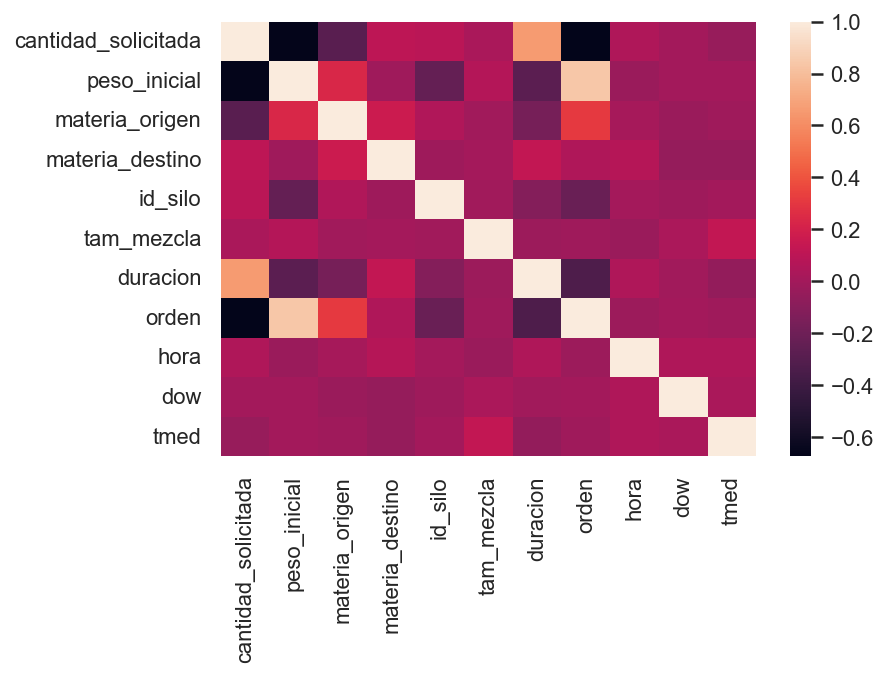

In [40]:
sns.heatmap(df_dosificaciones.corr())
plt.show()

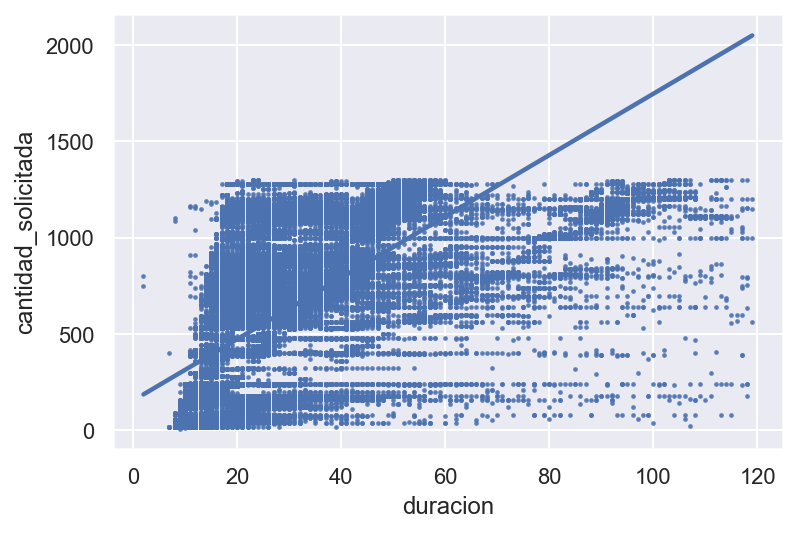

In [42]:
sns.regplot(data=df_dosificaciones, x='duracion', y='cantidad_solicitada', scatter_kws={'s':2});

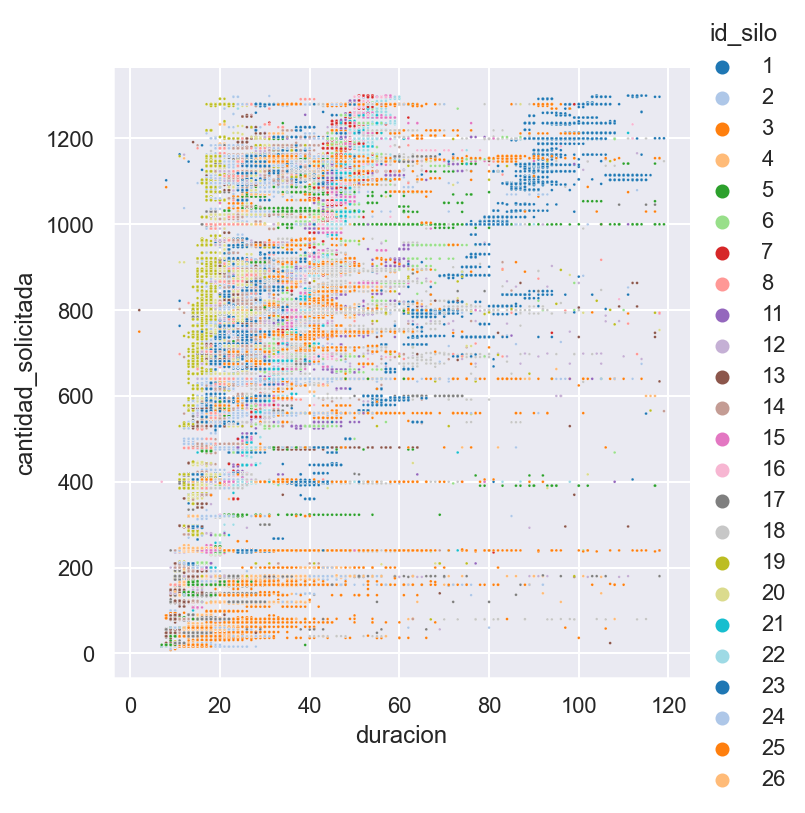

In [95]:
sns.relplot(data=df_dosificaciones, x='duracion', y='cantidad_solicitada', 
            s=2, hue='id_silo', palette='tab20');

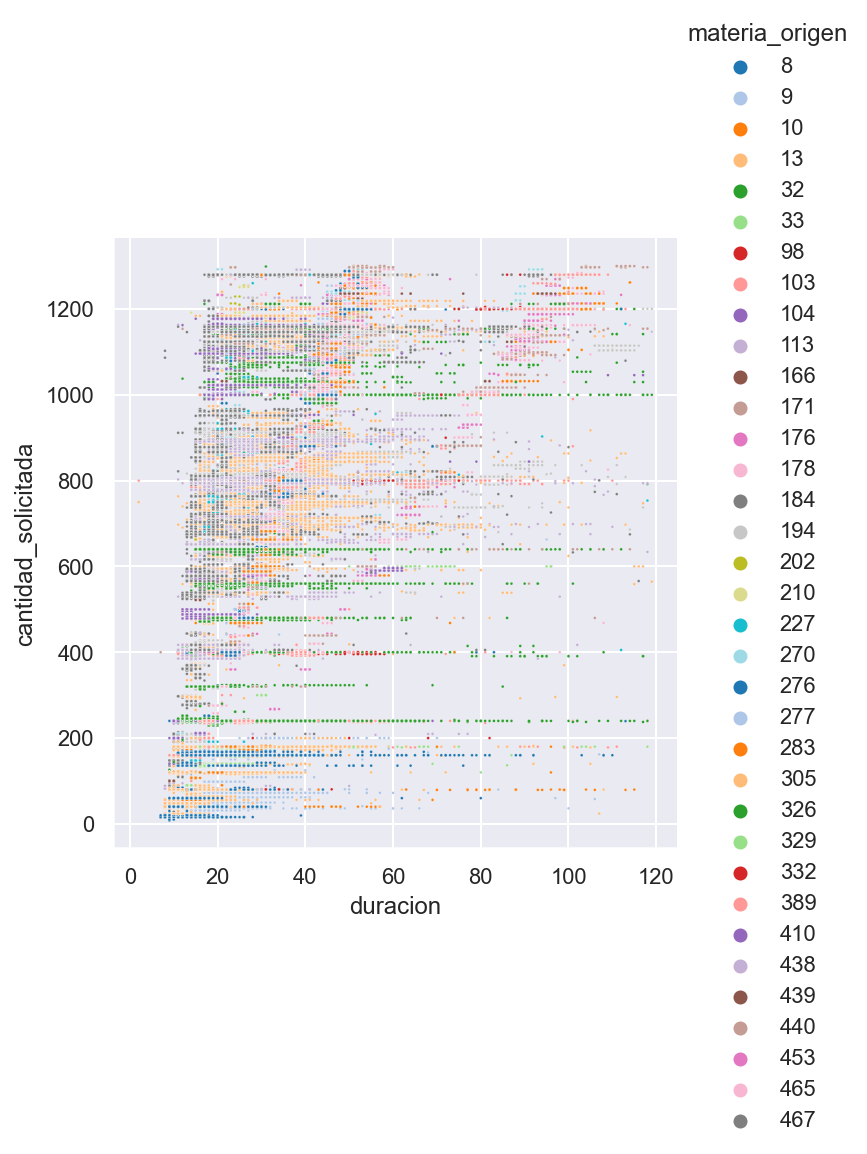

In [45]:
sns.relplot(data=df_dosificaciones, x='duracion', y='cantidad_solicitada', 
            s=2, hue='materia_origen', palette='tab20');

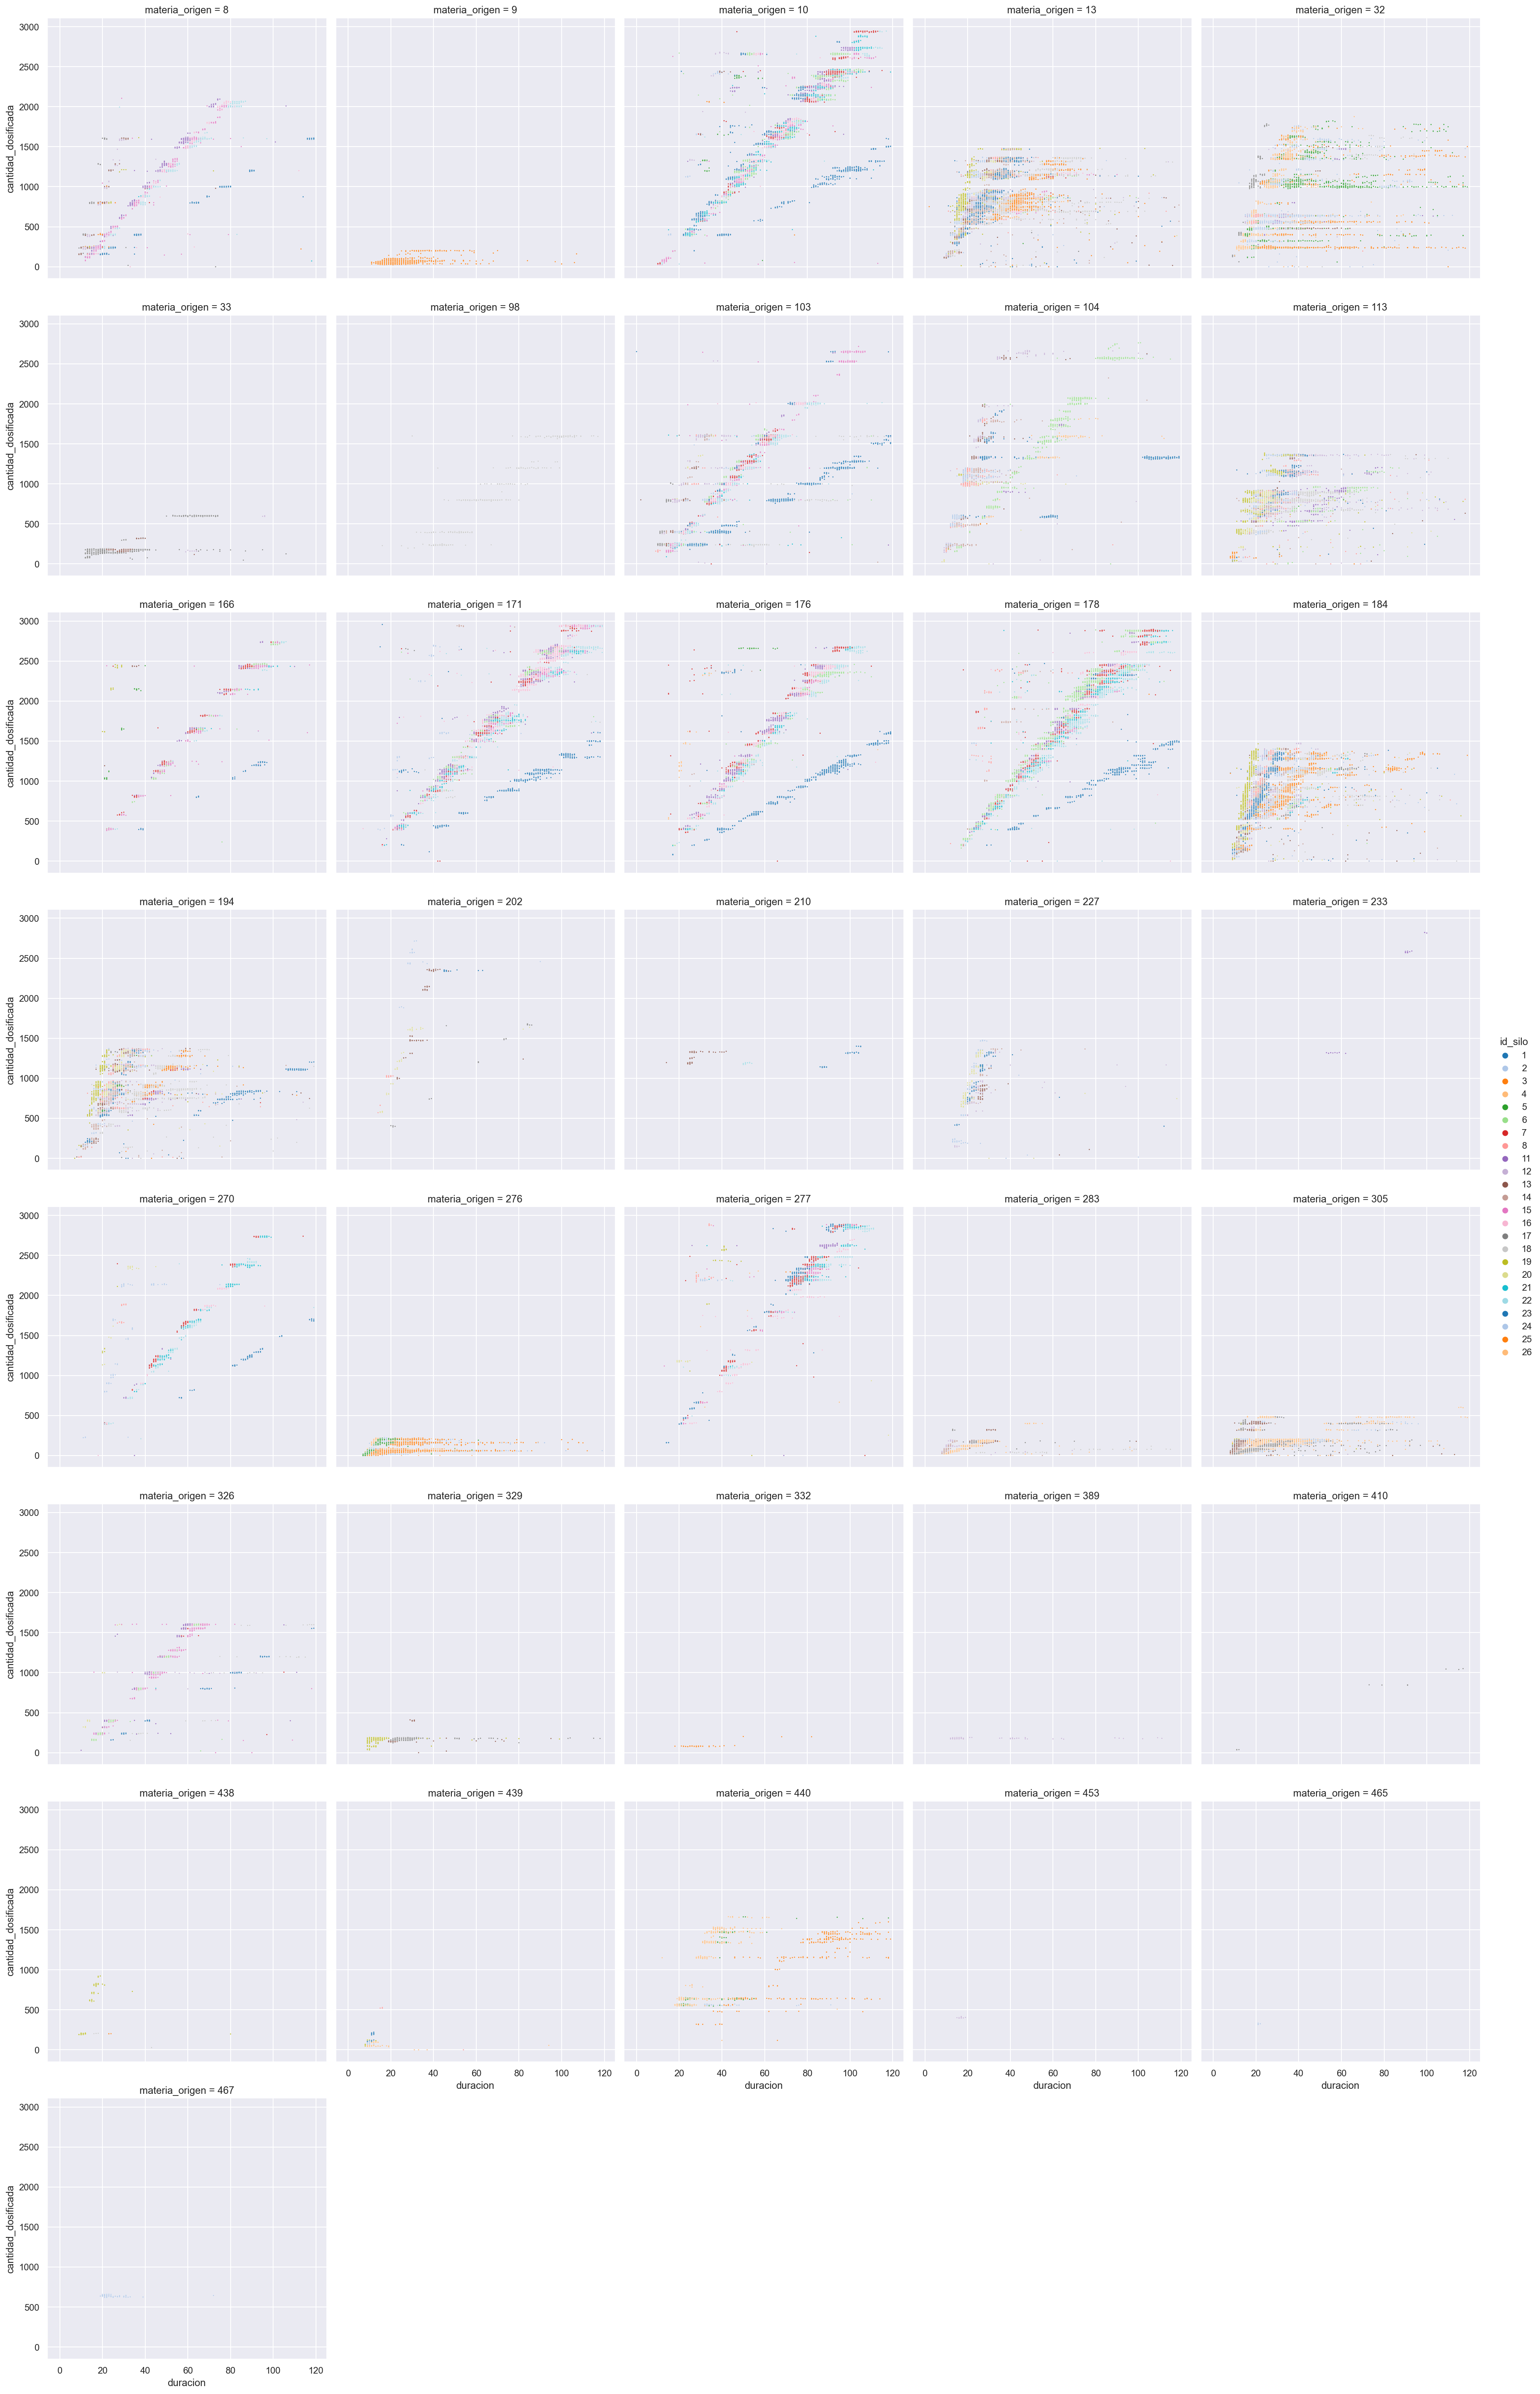

In [15]:
sns.relplot(data=df_dosificaciones, x='duracion', y='cantidad_solicitada', 
            s=2, hue='id_silo', col= 'materia_origen', col_wrap=5,  palette='tab20');

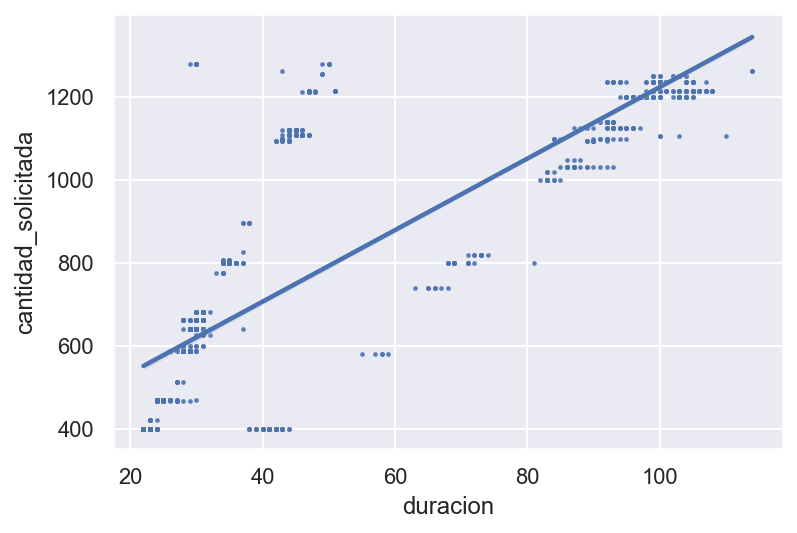

In [47]:
sns.regplot(data=df_dosificaciones[(df_dosificaciones['materia_origen']==10) & 
                                   (df_dosificaciones['id_silo']==1)], x='duracion', y='cantidad_solicitada', scatter_kws={'s':2});

Guardo los datos definitivos

In [48]:
df_dosificaciones.to_csv('datos/data_clean.zip', compression='zip')

In [49]:
for col in df_dosificaciones:
    print(col + ": " + str(df_dosificaciones[col].nunique()))
    if (df_dosificaciones[col].nunique() < 200):
        print(df_dosificaciones[col].unique())

cantidad_solicitada: 3467
peso_inicial: 2525
materia_origen: 35
[184 176   8 305 276 178   9  33 194  32 103 113 326 202  13 270 329 332
 277 227  10 166 283  98 389 171 410 210 104 439 440 438 467 465 453]
materia_destino: 58
[285 272 264 249  39  26 312  50  41 168 247 217  53 212  58 225 107 319
 323 321 317  48  25 314 118  49  46 215  35  61 278  62  37 310 220 291
  56 114 124 190  60 179 181 222 251 306 308 297 299 444 241 244 455 469
 472 478 484 493]
id_silo: 24
[14 15 13  1 26 20  8  7 25 16 12  2 17 23 24 21  6 19 22 11 18  3  4  5]
tam_mezcla: 46
[4000 4060 4040 4080 2000 2020 4010 4200  400 4100 4140 4400 4160 4150
 3030 4020 3000 3700 3500 4008 3005 3100 4250 4028 2525 4300 3380 4180
 4500 4340 4290 3600 4170 4350 2400 3350 3900 2100 2500 4280 4279 4274
 3850 4050 4090 4030]
duracion: 114
[ 41  46  26  47  22  25  45  44  28  27  39  30  31  24  23  90  91  89
  79  77  13  76  12  14  64  63  62  33  69  32  70  29  35  21  37  36
  51  50  80  17  15  78  20  11  34  48

<div style="text-align: right">
<a href="#inicio"><font size=5><i class="fa fa-arrow-circle-up" aria-hidden="true" style="color:#00586D"></i></font></a>
</div>

---

<a id="section8"></a>
## <font color="#00586D"> 8. Preprocesamiento</font>
<br>

Clasificaremos las variables en numéricas y categóricas y diseñaremos un Pipeline para el preprocesamiento de estos. Para las variables numéricas programaremos dos tareas, una imputación de valores nulos, y un escalado standard de los valores. En cuanto a las variables categóricas también imputaremos los valores perdidos y realizaremos un onehotencoder para binarizar todas las variables categóricas.
<br>

In [54]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

cat_features = ['materia_origen', 'materia_destino', 'id_silo', 'orden', 'hora', 'dow']#'mes', 'dia'
num_features = ['cantidad_solicitada','peso_inicial','tam_mezcla','tmed']

num_transformer = Pipeline([('imputer',SimpleImputer()),
                            ('standard_scaler', StandardScaler())])

cat_transformer = Pipeline([('simple_imputer', SimpleImputer(strategy='constant')),
                            ('one_hot_encoder', OneHotEncoder(handle_unknown='ignore'))])

column_trans = ColumnTransformer(
                transformers=[
                    ('num',num_transformer,num_features),
                    ('cat',cat_transformer,cat_features)])

<div style="text-align: right">
<a href="#inicio"><font size=5><i class="fa fa-arrow-circle-up" aria-hidden="true" style="color:#00586D"></i></font></a>
</div>

---

<a id="section9"></a>
## <font color="#00586D"> 9. División en train y test</font>
<br>

Una vez diseñado el preprocesamiento haremos una división de nuestros datos en train y test, el conjunto de datos de train lo utilizaremos para entrenar nuestros modelos y el de test para validarlos. La partición de los datos la haremos de un modo aleatorio, quedándonos con un 66% de los datos para entrenamiento y un 33% para el test.

In [55]:
from sklearn.model_selection import train_test_split

X = df_dosificaciones.drop('duracion',1)
y = df_dosificaciones['duracion']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

/Users/jlcasado/MCIDAEN/mc1-tfm/venv/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until


In [56]:
X.head()

,cantidad_solicitada,peso_inicial,materia_origen,materia_destino,id_silo,tam_mezcla,orden,hora,dow,tmed
0,768.557659,2,184,285,14,4000,1,22,0,13.95
1,1187.738199,1581,176,285,15,4000,2,22,0,13.95
2,768.557659,0,184,285,13,4000,1,22,0,13.95
3,1187.738199,1568,176,285,15,4000,2,22,0,13.95
4,768.557659,-19,184,285,13,4000,1,22,0,13.95


In [57]:
X_train_prep = column_trans.fit_transform(X_train)
X_test_prep  = column_trans.transform(X_test)

<div style="text-align: right">
<a href="#inicio"><font size=5><i class="fa fa-arrow-circle-up" aria-hidden="true" style="color:#00586D"></i></font></a>
</div>

---

<a id="section10"></a>
## <font color="#00586D"> 10. Entrenamiento de modelos</font>
<br>

Para finalizar nuestro trabajo, procederemos a entrenar diferentes modelos de regresión para compararlos y quedarnos con el que mejores resultados obtengamos para pasarlo a producción.
<br><br>
En cuanto a la validación, utilizaremos el error absoluto medio en todos los casos ya que nos indica claramente el error cometido y nos servirá para comparar los modelos.

Comenzaremos con la regresión lineal, vemos que es un modelo demasiado simple para representar nuestro problema, ya que tienen un error absoluto medio de 4.18 segundos.

In [58]:
from sklearn.linear_model import LinearRegression

linr_model = LinearRegression()

linr_model.fit(X_train_prep, y_train)

LinearRegression()

In [59]:
from sklearn.metrics import mean_absolute_error

y_pred = linr_model.predict(X_train_prep)
y_pred_test = linr_model.predict(X_test_prep)

print("Linear regression")
print("Error de entrenamiento: ", mean_absolute_error(y_train, y_pred))
print("Error de test: ", mean_absolute_error(y_test, y_pred_test))

Linear regression
Error de entrenamiento:  4.186807775485227
Error de test:  4.157275834985348


Para intentar mejorar el modelo anterior vamos a entrenar otro modelo basado en Ridge, esperando que se adapte mejor a los datos y evite un sobreajuste a los mismos. Antes de entrenar el modelo realizamos una busqueda de hiperparametros para 'ALPHA', que determina el peso de la penalización.
<br><br>
La mejora esperada no se produce, y el resultado es similar al anterior, quiza tampoco este tipo de modelos tienen la expresividad suficiente para un problema con tantos datos y características.

from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

lr_model = Ridge();

churn_pipe_lr = Pipeline([('prep', column_trans),
                            ('clas', lr_model)])

In [61]:
parameters = {}
parameters['prep__num__imputer__strategy'] = ['mean', 'median']
parameters['clas__alpha'] = [1,0.1,0.01,0.001,0.0001,0]

X_sample = X_train.sample(n=10000)
y_sample = y_train[X_sample.index]

GS = GridSearchCV(estimator=churn_pipe_lr, param_grid=parameters, scoring='neg_mean_squared_error', cv=5)
GS = GS.fit(X_sample, y_sample)	
    
print("Mejor score: ", GS.best_score_)
print("Mejore configuración de parámetros: ", GS.best_params_)


Mejor score:  -51.125238663046815
Mejore configuración de parámetros:  {'clas__alpha': 1, 'prep__num__imputer__strategy': 'mean'}


In [62]:
ridge_model = Ridge(alpha=1);

ridge_model.fit(X_train_prep, y_train) 

Ridge(alpha=1)

In [63]:
y_pred = ridge_model.predict(X_train_prep)
y_pred_test = ridge_model.predict(X_test_prep)

print("Error de entrenamiento: ", mean_absolute_error(y_train, y_pred))
print("Error de test: ", mean_absolute_error(y_test, y_pred_test))

Error de entrenamiento:  4.1884858523786175
Error de test:  4.159335317111079


In [64]:
import pickle
nombre_modelo = 'modelo_ridge.pkl'

pickle.dump(ridge_model, open(nombre_modelo,'wb'))

In [65]:
loaded_model = pickle.load(open(nombre_modelo, 'rb'))

In [66]:
y_pred = loaded_model.predict(X_test_prep)

In [67]:
print("Ridge")
print("Error de entrenamiento: ", mean_absolute_error(y_test, y_pred))

Ridge
Error de entrenamiento:  4.159335317111079


Por último intentaremos entrenar un modelo Random Forest, ya que este tipo de algoritmos son los que suelen obtener mejores resultados cuando estamos tratando con gran cantidad de datos y con un alto número de caracteristicas. Tambien realizaremos un busqueda de hiperparametros previa al entrenamiento definitivo para el número de estimadores, número maximo de variables y la máxima profundidad de los arboles.
<br><br>
Los resultados obtenidos son bastante satisfactorios, reduciendo el error absoluto a 1.3 segundos en entrenamiento.

In [68]:
from sklearn.model_selection import RandomizedSearchCV, RepeatedKFold

from sklearn.ensemble import RandomForestRegressor

# Se combinan los pasos de preprocesado y el modelo en un mismo pipeline.
pipe = Pipeline([('prep', column_trans),
                ('modelo',  RandomForestRegressor())])

# Optimización de hiperparámetros
# ==============================================================================
# Espacio de búsqueda de cada hiperparámetro

param_distributions = {
    'modelo__n_estimators': [50, 100, 200, 1000],
    'modelo__max_features': ["auto", 3, 5, 7, 10],
    'modelo__max_depth'   : [None, 3, 5, 10, 20]
}

# Búsqueda random grid
grid = RandomizedSearchCV(
        estimator  = pipe,
        param_distributions = param_distributions,
        n_iter     = 20,
        scoring    = 'neg_root_mean_squared_error',
        cv         = RepeatedKFold(n_splits = 5, n_repeats = 3),
        refit      = True, 
        verbose    = 0,
        random_state = 123,
        return_train_score = True
       )

In [69]:
X_sample = X_train.sample(n=2000)
y_sample = y_train[X_sample.index]

In [70]:
grid.fit(X = X_sample, y = y_sample)

# Resultados del grid
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = True)\
    .head(1)

,param_modelo__n_estimators,param_modelo__max_features,param_modelo__max_depth,mean_test_score,std_test_score,mean_train_score,std_train_score
14,50,3,3,-13.564441,0.556535,-13.474065,0.179532


In [71]:
print("Mejor score: ", grid.best_score_)
print("Mejore configuración de parámetros: ", grid.best_params_)

Mejor score:  -6.035756172995372
Mejore configuración de parámetros:  {'modelo__n_estimators': 200, 'modelo__max_features': 'auto', 'modelo__max_depth': 20}


In [73]:
rf_model = RandomForestRegressor(n_estimators=200,max_features='auto',max_depth=20)

rf_model.fit(X_train_prep, y_train)

RandomForestRegressor(max_depth=20, n_estimators=200)

In [74]:
y_pred = rf_model.predict(X_train_prep)
y_pred_test = rf_model.predict(X_test_prep)

print("Error de entrenamiento: ", mean_absolute_error(y_train, y_pred))
print("Error de test: ", mean_absolute_error(y_test, y_pred_test))

Error de entrenamiento:  1.3146854190761945
Error de test:  1.5586492684610767


In [75]:
import pickle
nombre_modelo_rf = 'modelo_rf.pkl'

pickle.dump(rf_model, open(nombre_modelo_rf,'wb'))

In [76]:
loaded_model_rf = pickle.load(open(nombre_modelo_rf, 'rb'))

In [77]:
y_pred = rf_model.predict(X_train_prep)
y_pred_test = loaded_model_rf.predict(X_test_prep)

print("Error de entrenamiento: ", mean_absolute_error(y_train, y_pred))
print("Error de test: ", mean_absolute_error(y_test, y_pred_test))

Error de entrenamiento:  1.3146854190761945
Error de test:  1.5586492684610767


Como hemos visto durante el analisis, parece que el comportamiento de las dosificaciones esta bastante caracterizado por el silo en el que se produce, por lo que vamos a realizar el entrenamiento del modelo Random Forest con datos de un solo silo. 
<br><br>
Los resultado vuelven a mejorar notablemente los anteriores, bajando el error en entrenamiento a 0.33 segundos.

In [80]:
df_dosif_silo1 = df_dosificaciones[df_dosificaciones['id_silo'] == 1]
df_dosif_silo1.head()

,cantidad_solicitada,peso_inicial,materia_origen,materia_destino,id_silo,tam_mezcla,duracion,orden,hora,dow,tmed
60,239.9952,2412,8,312,1,4000,24,1,5,1,14.85
63,239.9952,2414,8,312,1,4000,24,2,5,1,14.85
66,239.9952,2424,8,312,1,4000,26,1,5,1,14.85
70,239.9952,2413,8,312,1,4000,24,2,5,1,14.85
73,1200.0120,1825,8,50,1,4000,90,2,6,1,14.85


In [82]:
X = df_dosif_silo1.drop('duracion',1)
y = df_dosif_silo1['duracion']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

/Users/jlcasado/MCIDAEN/mc1-tfm/venv/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


In [83]:
X_train_prep = column_trans.fit_transform(X_train)
X_test_prep  = column_trans.transform(X_test)

In [84]:
rf_silo_model = RandomForestRegressor(n_estimators=200,max_features='auto',max_depth=20)

rf_silo_model.fit(X_train_prep, y_train)

RandomForestRegressor(max_depth=20, n_estimators=200)

In [85]:
y_pred = rf_silo_model.predict(X_train_prep)
y_pred_test = rf_silo_model.predict(X_test_prep)

print("Error de entrenamiento: ", mean_absolute_error(y_train, y_pred))
print("Error de test: ", mean_absolute_error(y_test, y_pred_test))

Error de entrenamiento:  0.38955144526895374
Error de test:  0.8710280881997813


In [86]:
nombre_modelo_silo_rf = 'modelo_silo_rf.pkl'

pickle.dump(rf_model, open(nombre_modelo_silo_rf,'wb'))

Por último, entrenaremos otro vez un modelo Random Forest con datos de un silo y una materia concreto para ver si esta es capaz de caracterizar aun más nuestro modelo.
<br><br>
No conseguimos mejorar los resultados, por lo que queda claro que la parte mecánica de la dosificación es la más determinante y con ella somos capace de obtener unos buenos resultados.

In [88]:
df_dosif_silo1_mat10 = df_dosificaciones[(df_dosificaciones['id_silo'] == 1) & 
                                         (df_dosificaciones['materia_origen'] == 10)]
df_dosif_silo1_mat10.head()

,cantidad_solicitada,peso_inicial,materia_origen,materia_destino,id_silo,tam_mezcla,duracion,orden,hora,dow,tmed
42515,1248.760000,-12,10,53,1,4000,99,1,0,1,15.20
42518,1248.760000,-24,10,53,1,4000,100,1,0,1,15.20
42521,1248.760000,-22,10,53,1,4000,99,1,0,1,15.20
42524,1248.760000,-23,10,53,1,4000,100,1,0,1,15.20
43431,1199.371994,1598,10,285,1,4000,95,2,4,2,14.45


In [90]:
X = df_dosif_silo1_mat10.drop('duracion',1)
y = df_dosif_silo1_mat10['duracion']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

/Users/jlcasado/MCIDAEN/mc1-tfm/venv/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


In [91]:
X_train_prep = column_trans.fit_transform(X_train)
X_test_prep  = column_trans.transform(X_test)

In [92]:
rf_silo_mat_model = RandomForestRegressor(n_estimators=200,max_features='auto',max_depth=20)

rf_silo_mat_model.fit(X_train_prep, y_train)

RandomForestRegressor(max_depth=20, n_estimators=200)

In [93]:
y_pred = rf_silo_mat_model.predict(X_train_prep)
y_pred_test = rf_silo_mat_model.predict(X_test_prep)

print("Error de entrenamiento: ", mean_absolute_error(y_train, y_pred))
print("Error de test: ", mean_absolute_error(y_test, y_pred_test))

Error de entrenamiento:  0.3543615234496303
Error de test:  0.8896792760443406


In [94]:
nombre_modelo_silo_mat_rf = 'modelo_silo_mat_rf.pkl'

pickle.dump(rf_model, open(nombre_modelo_silo_mat_rf,'wb'))